In [1]:
import numpy as np
import math as mth
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import Boundary_Functions as bf
import timeit
import tables
import h5py

#import Double_Null_utils as dnu
from mpmath import *
from decimal import *
from scipy.special import gamma as gamma
from scipy.special import gammaincc as gamma3
from scipy import optimize
from mpmath import gammainc as gamma2

#import warnings
#warnings.filterwarnings("ignore")

start = timeit.default_timer()

!jt -t onedork

In [2]:
uscal=20
vscal=10

In [3]:
rnputil=np.load('rnputil.npy')
wHD=rnputil[8]
print(wHD)

if wHD==True or wHD==1.0:
    urange=np.load('urange.npy')[::uscal]
    vrange=np.load('vrange.npy')[::vscal]
if wHD==False or wHD==0.0 or wHD==None:
    urange=np.load('urange.npy')
    vrange=np.load('vrange.npy')

1.0


In [4]:
if wHD==True or wHD==1.0:
    with h5py.File('rnp.h5','r') as f:
        r_group_key = list(f.keys())[0]
        rnpi=f[r_group_key]
        rnp = np.asarray(rnpi[::uscal,::vscal])
    with h5py.File('signp.h5','r') as f:
        sig_group_key = list(f.keys())[0]
        signpi=f[sig_group_key]
        signp = np.asarray(signpi[::uscal,::vscal])
    with h5py.File('phinp.h5','r') as f:
        phi_group_key = list(f.keys())[0]
        phinpi=f[phi_group_key]
        phinp = np.asarray(phinpi[::uscal,::vscal])
    with h5py.File('massnp.h5','r') as f:
        mass_group_key = list(f.keys())[0]
        massnpi=f[mass_group_key]
        massnp = np.asarray(massnpi[::uscal,::vscal])
    
    print(str(rnp.nbytes)+" bytes")
    print("Hd5 files used")

if wHD==False or wHD==0.0 or wHD==None:
    rnp=np.load('rnp.npy')
    signp=np.load('sig.npy')
    phinp=np.load('phi.npy')
    massnp=np.load('mass.npy')
    print("Numpy arrays used")
    
switchax=float(rnputil[9])
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    phinp=np.swapaxes(phinp,0,1)
    massnp=np.swapaxes(massnp,0,1)
    


11968000 bytes
Hd5 files used


In [5]:
print(rnputil)

N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0

M=massnp[0][-1]    
    
def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.6,1.288,55.0,-50],args=(M,Q,Lambda),tol=10**(-12), method='hybr')
rminus=sol.x[0]#+.035
rplus=sol.x[1]
rcosm=sol.x[2]
rneg=sol.x[3]

def dfr(r,M,Q,Lambda):
    return -2*(Lambda*r**4-3*M*r+3*Q**2)/(3*r**3)

print(rminus,rplus,rcosm,rneg)

print(fr(np.array([rminus,rplus,rcosm,rneg]),M,Q,Lambda))
    
    
    
numpoints=Nu*Nv
print(str(numpoints)+" points")

if Q==0.0:
    predtime=numpoints/(17530)
if Q>0.0:
    predtime=numpoints/(204896)
print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")

[2.9898e+08 1.4949e+04 2.0000e+04 2.0000e+00 1.0000e-02 1.0000e+00
 9.5000e-01 1.0000e-01 1.0000e+00 0.0000e+00]
N=298980000
0.6767481351833399 1.528728775478176 4.130469742840816 -6.335946653502331
[-5.55111512e-17  6.93889390e-17 -1.11022302e-16  2.22044605e-16]
1496000 points
Runtime: about 0.12 minutes


In [6]:
if M0==0.0:
    rlist=np.zeros((Nu,Nv))
    dr0u=-1/(4*dr0v)

    for i in range(0,Nu):
        for j in range(0,Nv):
            rlist[i][j]=ru0+dr0u/N*i+dr0v/N*j


In [7]:
if M0>0.0 and Q==0.0 and Lambda==0.0:
    ulist=np.empty((Nu))*np.nan
    vlist=np.empty((Nv))*np.nan
    
    #rlistu=ru0+bf.dr2(M0,dr0v,ru0)*np.arange(0,umax,du0)
    #rlistv=ru0+dr0v*np.arange(0,vmax,dv0)

    rlistu=rnp[:,0]
    rlistv=rnp[0,:]
    
    #print(rlistv)

    ulist=np.empty((Nu))
    vlist=np.empty((Nv))

    for i in range(0,Nu):
        if rlistu[i]>rminus:
            ulist[i]=bf.rbounschinv(M0,ru0,bf.dr2(M0,dr0v,ru0)*(bf.esig(M0,rlistu[0]))**(1),rlistu[i])
        else:
            ulist[i]=np.nan
    
    for j in range(0,Nv):
        vlist[j]=bf.rbounschinv(M0,ru0,dr0v*bf.esig(M0,rlistu[0])**(1),rlistv[j])

    #print(vlist)
    plt.plot(ulist)
    plt.show()

In [8]:
if M0>0.0 and Q==0.0 and Lambda==0.0:        
    rlist=np.zeros((Nu,Nv))*np.nan

    for i in range(0,Nu):
        for j in range(0,Nv):
            rlist[i][j]=bf.rsch(M0,ru0,dr0v,ulist[i],vlist[j])
            #if rlist[i][j]>0.0:
                #continue
            #else:
                    #rlistv[j]=np.nan
                #break
            

In [9]:
if M0>0.0 and Q>0.0 and Lambda==0.0:
    #rlistu=ru0+bf.dr2rn(M0,Q,dr0v,ru0)*np.arange(0,umax,du0)
    #rlistv=ru0+dr0v*np.arange(0,vmax,dv0)

    rlistu=rnp[:,0]
    rlistv=rnp[0,:]
    
    print(len(rnp[0]),len(rnp[:,0]))
    
    #print(bf.esigrn(M0,Q,ru0))
    #print(rlistu)

    ulist=np.empty((Nu))*np.nan
    vlist=np.empty((Nv))*np.nan
    
    print(len(rlistu))
    print(Nu)
    print(Nv)
    
    for i in range(0,Nu):
        if rlistu[i]>rminus:
            ulist[i]=bf.rbounrninv(float(rlistu[i]),M0,Q,ru0,bf.dr2rn(M0,Q,dr0v,ru0)*(bf.esigrn(M0,Q,rlistv[0]))**(1))
        else:
            ulist[i]=np.nan

    for i in range(0,Nv):
        vlist[i]=bf.rbounrninv(float(rlistv[i]),M0,Q,ru0,dr0v*(bf.esigrn(M0,Q,rlistv[0]))**(1))

    plt.plot(ulist)#,rlistu)
    plt.xlabel('numpoints')
    plt.ylabel('u')
    #plt.xlabel('u')
    #plt.ylabel('r')
    #plt.xlim(0,1)
    plt.ylim(0,5)
    plt.grid()
    plt.show()    
    
    plt.plot(vlist)#,rlistv)
    plt.xlabel('numpoints')
    plt.ylabel('v')
    #plt.xlabel('v')
    #plt.ylabel('r')
    #plt.xlim(0,1)
    #plt.ylim(4,5)
    plt.grid()
    plt.show()

    print(ulist)

In [10]:
if M0>0.0 and Q>0.0 and Lambda==0.0:
    rlist=np.zeros((Nu,Nv))*np.nan
    for i in range(0,Nu):
    #for j in range(0,Nv):
        rlist[i]=bf.rrn(M0,Q,ru0,dr0v,signp[i][0],ulist,vlist,i).reshape(Nv)

4.614583333333333


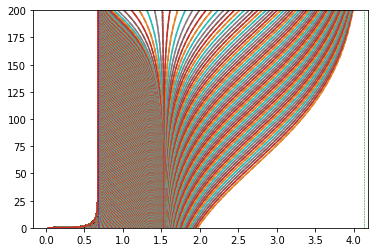

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


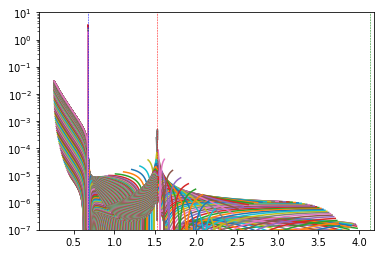

In [36]:
if M0>0.0 and Q>0.0 and Lambda>0.0:
    corfactor=1/dr0v*0.5*np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)
    print(corfactor)
    def vegiver(r,r0):
        C1=6/Lambda*(-(rcosm**2.0*np.log(rcosm-r0))/((rcosm-rminus)*(rcosm-rneg)*(rcosm-rplus))+(rminus**2.0*np.log(np.abs(r0-rminus)))/((rcosm-rminus)*(rminus-rneg)*(rminus-rplus))+(rneg**2.0*np.log(np.abs(r0-rneg)))/((rcosm-rneg)*(rneg-rminus)*(rneg-rplus))+(rplus**2.0*np.log(np.abs(r0-rplus)))/((rcosm-rplus)*(rplus-rminus)*(rplus-rneg)))
        f=6/Lambda*(-(rcosm**2.0*np.log(rcosm-r))/((rcosm-rminus)*(rcosm-rneg)*(rcosm-rplus))+(rminus**2.0*np.log(np.abs(r-rminus)))/((rcosm-rminus)*(rminus-rneg)*(rminus-rplus))+(rneg**2.0*np.log(np.abs(r-rneg)))/((rcosm-rneg)*(rneg-rminus)*(rneg-rplus))+(rplus**2.0*np.log(np.abs(r-rplus)))/((rcosm-rplus)*(rplus-rminus)*(rplus-rneg)))
    
        return -(C1-f)*corfactor
    
    #rlist=np.zeros((Nu,Nv))*np.nan
    #vlist= vegiver(rnp,rnp[0,0])
    
    
    #vrange2=np.cumsum(cornp)-cornp[0]
    
    numlines=747
    
    for i in range(0,numlines):
    #or line in rnp[::100]:
        #plt.plot(line,-vegiver(line,rnp[0,0])*corfactor)
        #plt.plot(line,vrange)
        rline=rnp[int(i/numlines*Nu+1)]
        #print(rline)
        plt.plot(rline,vegiver(rline,rline[0]),'--')
        plt.plot(rline,vrange)
        #print(vegiver(rline,rline[0]))
        #print(vrange)
        #print('--')
    plt.axvline(x=rplus,linewidth=0.5,linestyle='--',color='red')
    plt.axvline(x=rminus,linewidth=0.5,linestyle='--',color='blue')
    plt.axvline(x=rcosm,linewidth=0.5,linestyle='--',color='green')
    plt.ylim(0,vmax)
    plt.show()
    for i in range(0,numlines):
        rline=rnp[int(i/numlines*Nu+1)]
        plt.plot(rline,np.abs(vrange-vegiver(rline,rline[0]))/vegiver(rline,rline[0]))
    plt.axvline(x=rplus,linewidth=0.5,linestyle='--',color='red')
    plt.axvline(x=rminus,linewidth=0.5,linestyle='--',color='blue')
    plt.axvline(x=rcosm,linewidth=0.5,linestyle='--',color='green')
    plt.ylim(.0000001,10)
    plt.yscale('log')
    plt.show()
    
    
    

        
    

In [12]:
if f is p

SyntaxError: invalid syntax (<ipython-input-12-490cd3e3ff76>, line 1)

levels=np.arange(5.0, np.nanmax(rlist), 5.0 )
#levels=np.arange(5.0, 100, 5.0 )
levels=np.insert(levels,0,[rminus+.01,.7,1.0,rplus])

plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(rlist),cmap=plt.cm.cool,vmin=0.0,vmax=np.nanmax(rlist))
plot4=plt.contour(vrange,urange,rlist,levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange,urange,rlist, [rplus],linewidths=0.5,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rlist, [rminus],linewidths=1.0,linestyles='dashed',colors='blue',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
#plt.clabel(plot4, levels,  
           #inline=0, inline_spacing=0, 
           #fmt='%1.2f',rightside_up=True,
           #fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
#plt.xlim(0,20)
#plt.ylim(0,11)
plt.xlim(0,vmax)
#plt.ylim(9.2758,9.2761)
plt.colorbar(plot1)
plt.title('Radius vs (u,v) Coordinates')
#plt.savefig('EH-mismatch.png',dpi=300)
plt.show()


In [ ]:
print(Nu)
Ni=2500
while Ni<Nu:
    plt.plot(vrange,rlist[Ni,:])
    Ni+=100
plt.plot([0,vmax],[rminus,rminus],'r--',color='blue',linewidth=0.5)
plt.ylim(rminus-0.00000001,rminus+0.00000001)
plt.xlabel('v')
plt.ylabel('r')
plt.grid()
plt.show()



In [ ]:
print(Nu)

Ni=100
Numax=2000
while Ni<Numax:
    #plt.plot(vrange,rlist[Ni,:],'-.')
    #plt.plot(vrange,rnp[Ni,:])
    try:
        plt.plot(rlist[Ni,:],vrange,'-.')
        plt.plot(rnp[Ni,:],vrange)
    except:
        break
    #plt.plot(urange,rlist[:,Ni+1],'-.')
    #plt.plot(urange,rnp[:,Ni+1])
    Ni+=100
#plt.plot([0,vmax],[rplus,rplus],'r--',color='red',linewidth=0.5)
#plt.plot([0,vmax],[rminus,rminus],'r--',color='blue',linewidth=0.5)
#plt.ylim(rminus-0.1,rminus+0.1)
plt.ylabel('v')
plt.xlabel('r')
plt.xlim(1.31,1.315)
#plt.ylim(.6877460,.6877525)
#plt.ylim(.687749,.6877492)
plt.grid()
plt.title('u vs r(u) along v=const')
#plt.savefig('rminus-mismatch-u.png',dpi=300)
plt.show()

In [ ]:
rdiff=np.ma.masked_invalid(np.abs((rlist-rnp)/rlist))

In [ ]:
#np.ma.masked_invalid()

#print(rdiff[-100,:])
plt.plot(vrange,rdiff[700,:])
plt.plot(vrange,rdiff[100,:],label='u='+str(urange[100]))
plt.plot(vrange,rdiff[1000,:],label='u='+str(urange[1000]))
plt.plot(vrange,rdiff[2000,:],label='u='+str(urange[2000]))
#plt.plot(vrange,rdiff[3000,:],label='u='+str(urange[3000]))
plt.yscale('log')
plt.grid()
plt.xlabel('v')
plt.ylabel('Error in r')
plt.legend(loc='upper left')
plt.show()

print(len(urange),len(vrange),len(rdiff))

plt.plot(urange,rdiff[:,Nv-1],label='v='+str(vrange[Nv-1]))
plt.plot(urange,rdiff[:,int(Nv*3/4)],label='v='+str(vrange[int(Nv*3/4)]))
plt.plot(urange,rdiff[:,int(Nv*1/2)],label='v='+str(vrange[int(Nv*1/2)]))
plt.plot(urange,rdiff[:,1],label='v='+str(vrange[1]))



#plt.plot(urange,rdiff[:,-4000],label='v='+str(vrange[-4000]))
#ax= fig.add_subplot(1,1,1)
plt.yscale('log')
plt.grid()
plt.xlabel('u')
plt.ylabel('Error in r')
#handles, labels = plt.get_legend_handles_labels()
plt.legend(loc='upper left')
plt.show()

In [ ]:

if M0==0.0:
    levelsdiff=[10**(-11.0),10**(-10.0),10**(-9.0)]
if M0>0.0 and Q==0.0:
    levelsdiff=[.00001,.0001,.001]
if M0>0.0 and Q>0.0:
    levelsdiff=[10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2)]#,10**(-1)]#,10**(-1)]#,10**(-0),10**(1),20**(1),30**(1)]

plot1=plt.pcolormesh(vrange,urange,rdiff,cmap=plt.cm.cool, norm=colors.LogNorm(vmin=min(levelsdiff), vmax=max(levelsdiff)))#,vmin=0.0,vmax=.0001)
#plt.ylim(0,10.8)
plot4=plt.contour(vrange,urange,rdiff, levelsdiff,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange,urange,rlist, [rplus],linewidths=0.5,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange,urange,rnp, [rplus],linewidths=0.5,colors='green',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rlist, [rminus],linewidths=1.0,linestyles='dashed',colors='blue',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnp, [rminus+.00001],linewidths=1.0,linestyles='dashed',colors='purple',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
#fmt={str(10**(-2)):10**(-2)}
plt.clabel(plot4, levelsdiff,  
           inline=0, inline_spacing=0, 
           fmt='%1.6f',rightside_up=True,
           fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim(0,vmax)
#plt.ylim(9.27585,9.27615) #normal
#plt.ylim(9.27589,9.27597)
#plt.ylim(.4432,.44325)
plt.ylim(0,umax)
plt.colorbar(plot1)
plt.title('Fractional Error of r(u,v)')
plt.savefig('num-rel-pics/r-error.png',dpi=300)
plt.show()

In [ ]:
print("Max error is: "+str(np.nanmax(rdiff)))
print("Mean error is: "+str(np.nanmean(rdiff)))
print("Standard Deviation is: "+str(np.nanstd(rdiff)))
plt.plot(vrange,urange[np.argmax(rdiff,axis=0)])
plt.xlabel('v')
plt.ylabel('u')
plt.grid()
plt.show()
plt.plot(urange,vrange[np.argmax(rdiff,axis=1)])
plt.xlabel('u')
plt.ylabel('v')
plt.grid()
plt.show()

plt.plot(vrange,urange[np.argmax(rdiff,axis=0)])
plt.plot(vrange[np.argmax(rdiff,axis=1)],urange)
plt.xlabel('v')

plt.ylabel('u')
plt.grid()
plt.show()
#print(rlist[570,570])

#print(rdiff)

#Max error is: 0.523035549926
#Mean error is: 0.00250593093563
#Standard Deviation is: 0.012842896785

In [ ]:
stop = timeit.default_timer()

In [ ]:
acttime=stop - start

numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttimef=(acttime-predtime)/60

exttime=format(abs((acttime-predtime)/60),'.2f')
if exttimef>0.0:
    print("Took "+str(exttime)+" more minutes")
if exttimef<0.0:
    print("Took "+str(exttime)+" less minutes")
if exttimef==0.0:
    print("Took exactly the right time!!!!")

In [ ]:
plt.plot(vrange,rlist[300,:])
plt.ylim(1.5,5)
plt.xlim(0,60)
plt.xlabel('v')
plt.ylabel('r')
plt.grid()
plt.show()



In [ ]:
print(Nu)
urange2=[]
for i in range(0,Nu-1):
    urange2.append(urange[i+1]-urange[i])
print(np.argmin(urange2))
print(urange[np.argmin(urange2)])

In [ ]:
#uNEH=Nu-10
#ustep=1
#uN1=uNEH#uNEH-3000
uNEH=768
ustep=100
uN1=uNEH-700
Numax=Nu


uN=uN1
plt.plot([0,vmax],[rplus,rplus],'r--',color='red',linewidth=0.5, label='r+')
plt.plot([0,vmax],[rminus,rminus],'r--',color='blue',linewidth=0.5, label='r-')
while uN< Numax:
    if uN<uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'--',label='u='+str(urange[uN]))
    if uN==uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],label='u='+str(urange[uN]))
    if uN>uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'-.',label='u='+str(urange[uN]))
    #sample3=plt.plot(vrange,signp[uN1+uN,:])
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'$r$(u,v)')
plt.ylim(0,4)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.grid()
plt.title(r'$r$(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('rEH-RN.png',dpi=300,bbox_inches="tight")
plt.show()

uN=uN1
while uN< Numax:
    if uN<uNEH:
        sample3=plt.plot(vrange,signp[uN,:],'--',label='u='+str(uN))
    if uN==uNEH:
        sample3=plt.plot(vrange,signp[uN,:])
    if uN>uNEH:
        sample3=plt.plot(vrange,signp[uN,:],'-.')
    #sample3=plt.plot(vrange,signp[uN1+uN,:])
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'$\sigma$(u,v)')
plt.ylim(-50,50)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.title(r'$\sigma$(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('sigEH-RN.png',dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
#for j in range(0,Nv):
    #print(rnp[3300,j])

In [ ]:
du0=urange[1]-urange[0]
dv0=vrange[1]-vrange[0]

rnpnew=np.array([[rnp[0][0],rnp[0][1]],[rnp[1][0],np.nan]])
#signpnew=np.array([[0,0],[0,0]])
signpnew=np.array([[signp[0][0],signp[0][1]],[signp[1][0],np.nan]])
phinpnew=np.array([[0,0],[0,0]])

print(rnpnew)
print(signpnew)

#print(massnp[1][1])

print(dnu.x4giveralt(0,0,du0,dv0,rnpnew,phinpnew,signpnew,massnpf,1.0,.95,0.0,np.longdouble))

print(abs(rlist[1][1]-dnu.x4giveralt(0,0,du0,dv0,rnpnew,phinpnew,signpnew,massnp,1.0,.95,0.0,np.longdouble)[0]))

In [ ]:
rnpnew=np.array([[rlist[0][0],rlist[0][1]],[rlist[1][0],np.nan]])
#signpnew=np.array([[0,0],[0,0]])
#def siggiver(r,M0,Q):
    #sig=np.log(1-2*M0/r+Q**2/r**2)
signpnew=np.array
signpnew=np.array([[signp[0][0],signp[0][1]],[signp[1][0],np.nan]])
phinpnew=np.array([[0,0],[0,0]])

print(rnpnew)
print(signpnew)


print(dnu.x4giveralt(0,0,du0,dv0,rnpnew,phinpnew,signpnew,1.0,.95,0.0,np.longdouble))

print(abs(rlist[1][1]-dnu.x4giveralt(0,0,du0,dv0,rnpnew,phinpnew,signpnew,1.0,.95,0.0,np.longdouble)[0]))

In [ ]:
print(Nu,Nv)

#u4=4000
#v4=3500
u4=2000

v4=2000

print(urange[u4],vrange[v4])
print(rnp[u4][0])

In [ ]:
drua=np.zeros((Nu-1))
dru=np.zeros((Nu-1))

for i in range(0,Nu-1):
    drua[i]=(rlist[i+1][v4]-rlist[i][v4])/rlist[i][v4]#(urange[i+1]-urange[i])
    dru[i]=(rnp[i+1][v4]-rnp[i][v4])/rnp[i][v4]#(urange[i+1]-urange[i])

plt.plot(np.delete(urange,0),np.abs(dru),label='numerical')
plt.plot(np.delete(urange,0),np.abs(drua),'--',label='analytic')
plt.yscale('log')
plt.ylabel('|r,u|')
plt.xlabel('u')
#plt.xlim(1.8336,1.8345)
#plt.xlim(1.83,1.842)
#plt.ylim(10**(-3),10**(4))
plt.title('|r,u| at v='+str(vrange[v4]))
plt.legend(loc='lower right')
plt.grid()
#plt.savefig('ru.png',dpi=300)
plt.show()

print(urange[np.argmax(np.abs(dru))])
rnp[np.argmax(np.abs(dru))]

In [ ]:
drva=np.zeros((Nv-1))
drv=np.zeros((Nv-1))


for j in range(0,Nv-1):
    drva[j]=(rlist[u4][j+1]-rlist[u4][j])/(vrange[j+1]-vrange[j])
    drv[j]=(rnp[u4][j+1]-rnp[u4][j])/(vrange[j+1]-vrange[j])

plt.plot(np.delete(vrange,0),np.abs(drv),label='numerical')
plt.plot(np.delete(vrange,0),np.abs(drva),'--',label='analytic')
plt.yscale('log')
plt.ylabel('|r,v|')
plt.xlabel('v')
plt.grid()
plt.title('|r,v| at u='+str(round(urange[u4],3)))
plt.legend(loc='upper right')
#plt.ylim(.1,1)
#plt.savefig('rv.png',dpi=300)
plt.show()



In [ ]:
druf=np.abs((drua[:]-dru[:])/drua[:])
plt.axvline(x=1.835,linestyle='--',color='red')
plt.plot(np.delete(urange,0),druf)

#plt.plot(np.delete(urange,0),np.abs(drua),'--')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(1.8339,1.8341)
plt.ylabel('Error in r,u')
plt.xlabel('u')
#plt.xlim(1.83,1.842)
plt.grid()
plt.title('Fractional Error of r,u')
#plt.savefig('ru-error.png',dpi=300)
plt.show()

In [ ]:
signp2=np.delete(signp,0,axis=1)
drvf=np.abs((drva[:]-drv[:])/drva[:])
drvf2=np.abs((drva[:]-drv[:])/drva[:]*np.exp(signp2[u4,:]))

plt.plot(np.delete(vrange,0),drvf)
#plt.plot(np.delete(vrange,0),drvf2)
#plt.plot(np.delete(urange,0),np.abs(drua),'--')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(1.8339,1.8341)
plt.ylabel('Error in r,v')
plt.xlabel('v')
plt.xlim(0,vmax)
plt.title('Fractional Error of r,v')
plt.grid()
#plt.savefig('rv-error.png',dpi=300)
plt.show()

In [ ]:
r=rnp[u4][v4]

print(dru[u4],drv[v4],mth.exp(-signp[u4][v4]))
print(drua[u4],drva[v4],mth.exp(-signp[u4][v4]))
print(dru[u4]*drv[v4]*mth.exp(-signp[u4][v4]))
print(drua[u4]*drva[v4]*mth.exp(-signp[u4][v4]))
print((1+4*drua[u4]*drva[v4]*mth.exp(-signp[u4][v4]))*r/2+Q**2/(2*r))
print(-1/4*(1-2*M0/r+Q**2/r**2))

In [ ]:
du=urange[u4+1]-urange[u4]
dv=vrange[v4+1]-vrange[v4]
print(dnu.x4giveralt(u4,v4,du,dv,rnp,phinp,signp,massnp,M0,Q,0.0,object))
print(dnu.x4giveralt(0,0,du,dv,rnp,phinp,signp,massnp,M0,Q,0.0,object))

In [ ]:
vmar=rnp[u4][v4]
print(r)
print("M="+str((1.0+4.0*np.exp(-signp[u4][v4])*dru[u4]*drv[v4])*r/2+Q**2.0/(2.0*r)))
print(massnp[u4][v4])

In [ ]:
mth.exp(-27)*10**(-3)+1
print(mth.exp(signp[u4][v4]))
print("%.32f" % (mth.exp(signp[u4][v4])/(25*4*.6877*1000)*(1-.95**2/.6877**2)))
print("%.32f" % (mth.exp(signp[u4][v4])/(25*4*.6877*1000)*(1-.95**2/.6877**2)+1))
print(urange[u4+1]-urange[u4])


In [ ]:
getcontext().prec=32

In [ ]:
Decimal(mth.exp(signp[u4][v4])/(25*4*.6877*1000)*(1-.95**2/.6877**2))+Decimal(1)

In [ ]:
np.array([Decimal(Decimal(-19).exp())+1])+np.array([1])

In [ ]:
Decimal(mth.exp(Decimal(-19)))+Decimal(1)

In [ ]:
Decimal(.95)+1

In [ ]:
du0*dv0*(Decimal(signp[u4][v4])).exp()*(Q**Decimal(2)-M0*rnp[u4][v4])/(Decimal(2)*rnp[u4][v4]**Decimal(3))

In [ ]:
(10**(-20)+1.0)-1.0